In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import time
import os
import cv2
import random
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.nn.functional as F
from PIL import Image

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#!unzip '/content/drive/MyDrive/DL/PROYECTO 1/archive (1).zip' -d '/content/drive/MyDrive/DL/PROYECTO 1'

In [27]:
#def quitar_transparencia(imagen_con_transparencia, color_de_fondo=(255, 255, 255)):
 #   imagen_sin_transparencia = Image.new("RGB", imagen_con_transparencia.size, color_de_fondo)
  #  imagen_sin_transparencia.paste(imagen_con_transparencia, mask=imagen_con_transparencia.split()[3])
   # return imagen_sin_transparencia

# Directorio que contiene las imágenes con transparencia
#directorio_imagenes = "/content/drive/MyDrive/DL/PROYECTO 1/pokemon/pokemon"

# Directorio donde se guardarán las imágenes sin transparencia
#directorio_destino = "/content/drive/MyDrive/DL/PROYECTO 1/pokemon_jpg/pokemon_jpg"

# Crear el directorio de destino si no existe
#if not os.path.exists(directorio_destino):
 #   os.makedirs(directorio_destino)

# Iterar sobre todas las imágenes en el directorio
#for nombre_imagen in os.listdir(directorio_imagenes):
 #   ruta_imagen = os.path.join(directorio_imagenes, nombre_imagen)

    # Ignorar archivos que no sean imágenes
  #  if not nombre_imagen.endswith(('.png', '.jpg', '.jpeg')):
   #     continue

    # Abrir la imagen con transparencia
  #  imagen_con_transparencia = Image.open(ruta_imagen)

    # Quitar la transparencia
   # imagen_sin_transparencia = quitar_transparencia(imagen_con_transparencia)

    # Guardar la imagen sin transparencia en el directorio de destino
    #ruta_imagen_sin_transparencia = os.path.join(directorio_destino, nombre_imagen)
    #imagen_sin_transparencia.save(ruta_imagen_sin_transparencia)

    #print("Transparencia eliminada y la imagen sin transparencia ha sido guardada como:", ruta_imagen_sin_transparencia)


In [28]:
# Función para cargar las imágenes
def load_images_from_folder(folder, target_size=(64, 64)):
    """
    Carga las imágenes de la carpeta especificada y las redimensiona al tamaño objetivo.
    """
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            # Redimensionar la imagen
            img = img.resize(target_size)
            # Convertir a formato RGB y asegurarse de que tenga solo 3 canales
            img = img.convert('RGB')
            images.append(np.array(img))
            # Asigna una etiqueta (por ejemplo, 0 para entrenamiento, 1 para prueba)
            labels.append(0 if random.random() < 0.8 else 1)
    return np.array(images), np.array(labels)

# Directorio donde están tus imágenes
root_directory = '/content/drive/MyDrive/DL/PROYECTO 1/pokemon_jpg/pokemon_jpg'

# Cargar las imágenes y las etiquetas
images, labels = load_images_from_folder(root_directory)

# Normalizar las imágenes
images = images.astype('float32') / 255

# Dividir las imágenes y las etiquetas en conjuntos de entrenamiento y prueba
split_ratio = 0.8
split_index = int(len(images) * split_ratio)

X_train, Y_train = images[:split_index], labels[:split_index]
X_test, Y_test = images[split_index:], labels[split_index:]

In [29]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de Y_train:", Y_train.shape)
print("Shape de Y_test:", Y_test.shape)

Shape de X_train: (655, 64, 64, 3)
Shape de X_test: (164, 64, 64, 3)
Shape de Y_train: (655,)
Shape de Y_test: (164,)


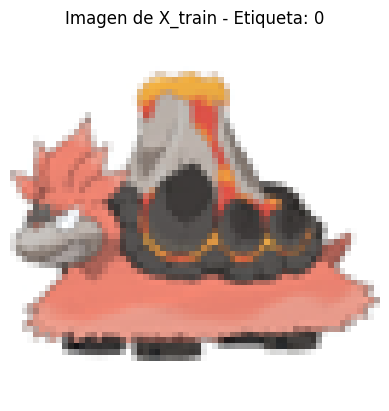

In [30]:
# Selecciona un índice aleatorio dentro del rango de X_train
index = np.random.randint(0, len(X_train))

# Muestra la imagen correspondiente a ese índice
plt.imshow(X_train[index])
plt.title(f'Imagen de X_train - Etiqueta: {Y_train[index]}')
plt.axis('off')  # Desactiva los ejes
plt.show()

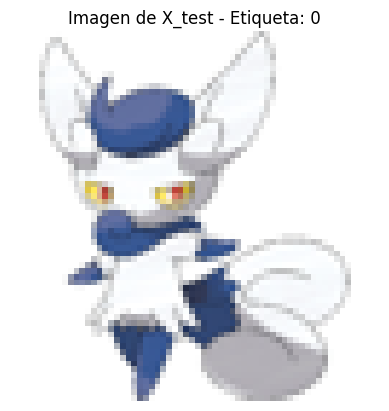

In [31]:
# Selecciona un índice aleatorio dentro del rango de X_test
index = np.random.randint(0, len(X_test))

# Muestra la imagen correspondiente a ese índice
plt.imshow(X_test[index])
plt.title(f'Imagen de X_test - Etiqueta: {Y_test[index]}')
plt.axis('off')  # Desactiva los ejes
plt.show()

In [32]:
type(X_train)

numpy.ndarray

In [33]:
# Definir constantes
batch_size = 32  # Tamaño del lote para el entrenamiento
latent_dim = 128  # Dimensión latente para el modelo
epochs = 50  # Número de épocas de entrenamiento
input_shape = X_train.shape[1:]  # Forma de entrada para el modelo

In [34]:
# Función de muestreo
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0] # Obtiene el tamaño del lote (número de muestras) de z_mean
    dim = K.int_shape(z_mean)[1] # Obtiene la dimensión de z_mean
    epsilon = K.random_normal(shape=(batch, dim)) # Genera muestras aleatorias de una distribución normal con media 0 y desviación estándar 1 (epsilon) con la forma (batch, dim)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon # Calcula y devuelve muestras de la distribución latente, utilizando la fórmula de muestreo de la distribución normal utilizando la media (z_mean), la desviación estándar (z_log_var), y las muestras aleatorias (epsilon).

In [35]:
# Definir encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = BatchNormalization()(x) # Se realiza normalización por lotes en las activaciones de la capa anterior.
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
shape_before_flattening = K.int_shape(x) # Se guarda la forma de los datos antes de aplanarlos. Esto será útil más tarde durante el proceso de decodificación.
x = Flatten()(x) #  Se aplana la salida de la última capa convolucional para prepararla para la capa densa.
x = Dense(512, activation="relu")(x)

# Definir sampling
z_mean = Dense(latent_dim, name='z_mean')(x) # Capa densa que produce las medias de la distribución latente.
z_log_var = Dense(latent_dim, name='z_log_var')(x) # Capa densa que produce los logaritmos de las varianzas de la distribución latente.
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) # Se define una capa Lambda que muestrea puntos de la distribución latente utilizando las medias y los logaritmos de las varianzas obtenidas anteriormente.

In [36]:
latent_dim, shape_before_flattening

(128, (None, 4, 4, 256))

In [37]:
inputs.shape

TensorShape([None, 64, 64, 3])

In [38]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 32)           128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 64)           18496     ['batch_normalization_8[

In [39]:
# Definir decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(np.prod(shape_before_flattening[1:]), activation="relu")(latent_inputs)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x) # Se aplica normalización por lotes para normalizar las activaciones de la capa anterior y acelerar el entrenamiento de la red.
x = Conv2DTranspose(128, 3, activation="tanh", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="tanh", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, activation="tanh", strides=2, padding="same")(x)
x = BatchNormalization()(x)
outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

In [40]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              528384    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 256)         590080    
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 128)       2950

In [41]:
outputs = decoder(z)
vae = Model(inputs, outputs, name='vae')

In [42]:
# Definir VAE loss
reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs)) * np.prod(input_shape)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

In [43]:
outputs.shape

TensorShape([None, 64, 64, 3])

In [44]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = vae.fit(X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, None),
                  callbacks=[early_stopping])

Epoch 1/50
21/21 [==============================] - 23s 875ms/step - loss: 1853.6914 - val_loss: 1859.0938
Epoch 2/50
21/21 [==============================] - 16s 767ms/step - loss: 1079.3834 - val_loss: 1048.1123
Epoch 3/50
21/21 [==============================] - 16s 780ms/step - loss: 646.1483 - val_loss: 797.8155
Epoch 4/50
21/21 [==============================] - 16s 773ms/step - loss: 495.3309 - val_loss: 850.6284
Epoch 5/50
21/21 [==============================] - 16s 775ms/step - loss: 468.8394 - val_loss: 879.5506
Epoch 6/50
21/21 [==============================] - 17s 799ms/step - loss: 457.9982 - val_loss: 843.3147
Epoch 7/50
21/21 [==============================] - 16s 771ms/step - loss: 441.7314 - val_loss: 821.8715
Epoch 8/50
21/21 [==============================] - 18s 866ms/step - loss: 426.6510 - val_loss: 757.2320
Epoch 9/50
21/21 [==============================] - 16s 769ms/step - loss: 418.0638 - val_loss: 714.2173
Epoch 10/50
21/21 [==============================] 

In [45]:
# Obtener z_mean, z_log_var para un lote de imágenes de entrada
z_mean_batch, z_log_var_batch, _ = encoder.predict(X_test)

# Utilizar la función de muestreo para generar muestras de la distribución latente
latent_samples = sampling([z_mean_batch, z_log_var_batch])

# Decodificar las muestras generadas para obtener imágenes "inventadas"
decoded_images = decoder.predict(latent_samples)

6/6 [==============================] - 1s 154ms/step


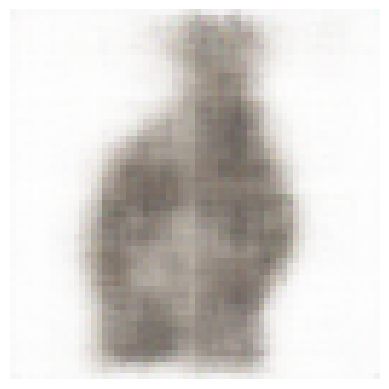

In [47]:
# Elegir una de las imágenes generadas para mostrar
image_to_show = decoded_images[0]

# Mostrar la imagen generada
plt.imshow(image_to_show)
plt.axis('off')
plt.show()

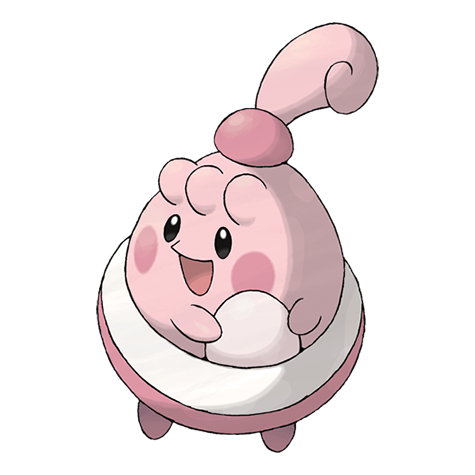



SE PARECE A HAPPINY!!!